# Fid light acquisition offsets

In this notebook we review fid light position data and determine a model to calculate the expected fid light positions based on the chandra_aca.drift model (last fit 2022-11).

Out of this work, the relationship between the chandra_aca.drift aimpoint model and the fid light position offsets is described as 

```
fid offset y = -1 * (aimpoint drift model dy at t_ccd) + 19.6 arcsecs
fid offset z = -1 * (aimpoint drift model dz at t_ccd) + 20.1 arcsecs
```



In [1]:
import os
os.environ['SKA'] = '/Users/jean/ska'
import sys

In [2]:
from pathlib import Path
import astropy.units as u
from astropy.table import Table
from cheta import fetch_sci as fetch

import ska_dbi
from cxotime import CxoTime
from ska_matplotlib import plot_cxctime
import matplotlib.pyplot as plt
import numpy as np

### Data collection

To calibrate a new model of the relationship between the acquisition temperature and the fid position at acquisition,
we use the pre-existing aimpoint drift model, details of the observed fid position at acquisition, and the commanded fid position.  The commanded fid position comes from the starcheck catalog data (positions determined and commanded with FEB07 fid characteristics). The fid position at acquisition comes from a fid light statistics database (fid_stats.db3) local to the project (and available for reference at the url) -- this database includes the median observed position during the first 1000 sec for each fid light.

In [3]:
# Retrieve two fid stats data files on the web
import urllib.request
url = "https://cxc.harvard.edu/mta/ASPECT/ipynb/chandra_aca_fid_offset/fid_stats.db3"
if not Path("fid_stats.db3").exists():
    urllib.request.urlretrieve(url, "fid_stats.db3");
url = "https://cxc.harvard.edu/mta/ASPECT/ipynb/chandra_aca_fid_offset/fid_commands_telem.dat"
if not Path("fid_commands_telem.dat").exists():
    urllib.request.urlretrieve(url, "fid_commands_telem.dat");

In [4]:
fid_observation_db = "./fid_stats.db3"

# Set the initial range for data exploration
start = CxoTime('2001:001')
stop = CxoTime.now()

# Gather Data
# Make a text file that includes the joined information (fid observed data/star catalogs cmd position)
# to save time when reexamining the data.
# If this file already exists (and it should from the web query above) just load it.
fid_data_file = 'fid_commands_telem.dat'
if not Path(fid_data_file).exists():
    sys.path.insert(0, "/Users/jean/git/chandra_aca")
    import fid_drift_mon.plot_command_vs_telem
    from fid_drift_mon.plot_command_vs_telem import (get_fids_telem, get_fids_commands,
                                                     get_dwells_with_fids, join_commands_telem)
    # Turn off the logger
    fid_drift_mon.plot_command_vs_telem.logger.setLevel('ERROR')
    # These methods from the plot_command_vs_telem module get the observed fid data for each fid for
    # each observation and combine that information with the commanded star catalog information
    dwells = get_dwells_with_fids(start.date, stop.date);
    fids_commands = get_fids_commands(dwells);
    with ska_dbi.DBI(dbi='sqlite', server=FID_STATS_PATH('.')) as db:
        fids_telem = get_fids_telem(dwells, fids_commands, db)
    commands_telem = join_commands_telem(fids_commands, fids_telem)
    commands_telem.write(fid_data_file, format='ascii')
else:
    commands_telem = Table.read(fid_data_file, format='ascii')

## Review data over the limit

During the interval after the 2022:294 save mode and before the fid search box sizes were increased to 40 arcsecs, the Y angles sometimes exceeded the 20 arcsec halfwidth, yet fid lights were still acquired. 

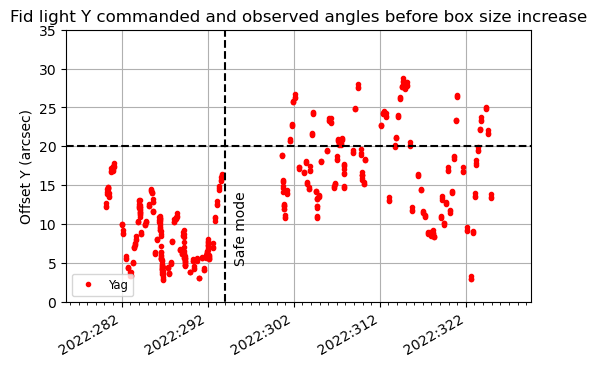

In [5]:

plt.figure(1, figsize=(6, 4))
ok = ((commands_telem['tstart'] > CxoTime('2022:280').secs)
      & (commands_telem['tstart'] < CxoTime('2022:325').secs))
tstart = commands_telem["tstart"][ok]
dyag = commands_telem["aoacyan"][ok] - commands_telem["yang"][ok]
plot_cxctime(tstart, dyag, "r.", label=f"Yag")
plt.ylim(-0, 35)
plt.grid()
plt.legend(fontsize="small", numpoints=1, loc="lower left")
plt.ylabel("Offset Y (arcsec)")
plt.title("Fid light Y commanded and observed angles before box size increase")
x0, x1 = plt.xlim()
dx = (x1 - x0) * 0.05
x0, x1 = x0 - dx, x1 + dx
plt.xlim(x0, x1)
plt.hlines([-20, 20], x0, x1, colors="k", linestyles="--")
# plot a vertical line
plt.vlines(CxoTime('2022:294').plot_date, -20, 45, colors="k", linestyles="--");
ax1 = plt.gca()
ax1.annotate("Safe mode", xy=(CxoTime('2022:294').plot_date + 1, 5), rotation=90);
#plt.savefig("overlimit.png")


In [6]:
np.max(dyag)

28.834485837822058

These data suggest that exceeding the limit by up to 5 arcsecs should be reasonable in operations. 

## Fit fid aimpoint drift model

The chandra_aca.drift model already captures an ACA offset that describes changes in fid positions with temperature, but is calibrated have a zero point that places the *aimpoint* at the zero-offset aimpoint position -- it does not include the reference offsets/calibration required to place the fid lights at their expected (FEB07 fid calibration) positions. Below, we use the residuals of the FEB07 fid calibration positions and values of the aimpoint drift model to calibrate offsets at the acquisition temperatures to the aimpoint drift model.


### Fit in Y

Calculate the aimpoint model drift values in Y for the acquisition temperatures in the calibration data set.

In [7]:
commands_telem.sort('tstart')
tstart = commands_telem["tstart"]
ok = ((commands_telem['tstart'] > CxoTime('2021:001').secs)
      & (commands_telem['tstart'] < CxoTime('2023:047').secs))
dat = fetch.Msid('AACCCDPT', tstart[ok][0], tstart[ok][-1], stat='5min')
from chandra_aca.drift import AcaDriftModel, DRIFT_PARS, SIM_MM_TO_ARCSEC
drift_y = AcaDriftModel(**DRIFT_PARS['dy']) 
t_ccd = np.interp(tstart[ok], dat.times, dat.vals)
dy = drift_y.calc(tstart[ok], t_ccd) 

Calculate offset of the fid positions to the aimpoint drift model. The offset is just the mean of the residuals.

Here we define the residuals as 
```
observed position - (fid commanded position + -1 * aimpoint drift calculated value)
```

In [8]:
y_offset = np.round(np.mean(commands_telem['aoacyan'][ok] - (commands_telem['yang'][ok] - dy)), 1)
print(f"y_offset is {y_offset}")

y_offset is 19.6


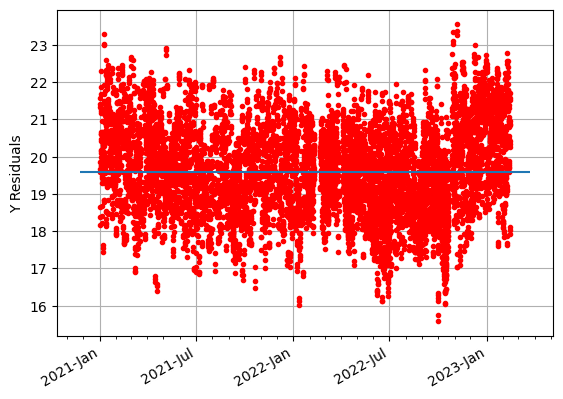

In [9]:
plot_cxctime(commands_telem['tstart'][ok], commands_telem['aoacyan'][ok] - (commands_telem['yang'][ok] - dy), 'r.')
xlims = plt.xlim()
plt.hlines(y_offset, xlims[0], xlims[1])
plt.ylabel("Y Residuals")
plt.grid()

### Fit in Z

Calculate the aimpoint drift model values in Z for the acquisition temperatures in the calibration data set.

In [10]:
drift_z = AcaDriftModel(**DRIFT_PARS['dz']) 
t_ccd = np.interp(tstart[ok], dat.times, dat.vals)
dz = drift_z.calc(tstart[ok], t_ccd)

Calculate the offset as the mean of the residuals.

In [11]:
z_offset = np.round(np.mean(commands_telem['aoaczan'][ok] - (commands_telem['zang'][ok] - dz)), 1)
print(f"z_offset is {z_offset}")

z_offset is 20.1


Plot up the residuals to look at trends over time.

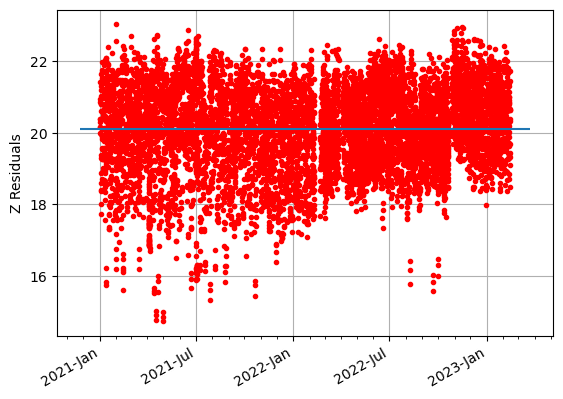

In [12]:
plot_cxctime(commands_telem['tstart'][ok], commands_telem['aoaczan'][ok] - (commands_telem['zang'][ok] - dz), 'r.')
xlims = plt.xlim()
plt.hlines(z_offset, xlims[0], xlims[1])
plt.ylabel("Z Residuals")
plt.grid()

### Evaluate new "fid position offset model"

Evaluate the position residuals over a longer but still modern period to confirm these offsets are reasonable in Y and Z.

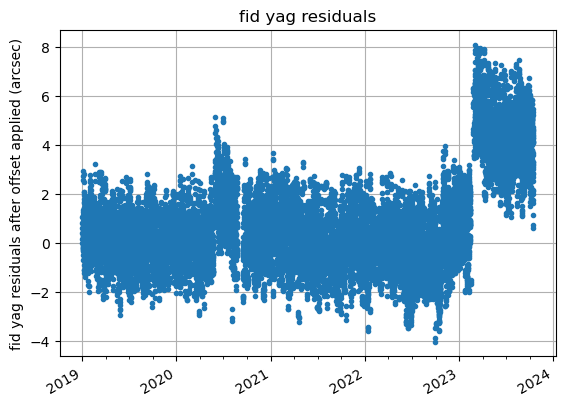

In [13]:
# Make a plot of Y fid residuals over modern times
ok = commands_telem['tstart'] > CxoTime('2019:001').secs
tstart = commands_telem['tstart'][ok]
dat = fetch.Msid('AACCCDPT', tstart[0], tstart[-1], stat='5min')
t_ccd = np.interp(tstart, dat.times, dat.vals)
dy = drift_y.calc(tstart, t_ccd)
plot_cxctime(tstart,
            (commands_telem['aoacyan'][ok] - commands_telem['yang'][ok]) - (-1 * dy + y_offset),
            '.')

plt.title('fid yag residuals')
plt.ylabel('fid yag residuals after offset applied (arcsec)')
plt.grid();
#plt.savefig("fid_yag_offset_residuals.png")

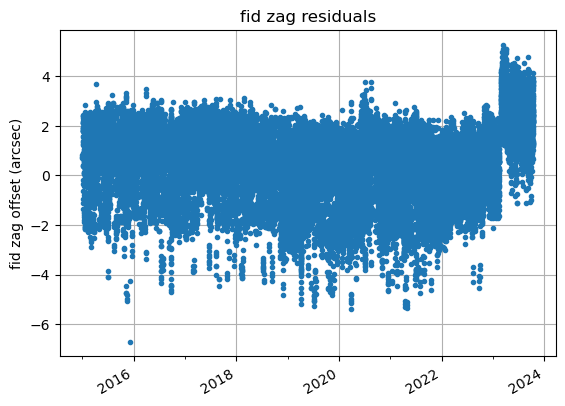

In [14]:
# Make a plot of Z fid residuals over modern times
ok = commands_telem['tstart'] > CxoTime('2015:001').secs
tstart = commands_telem['tstart'][ok]
dat = fetch.Msid('AACCCDPT', tstart[0], tstart[-1], stat='5min')
t_ccd = np.interp(tstart, dat.times, dat.vals)
dz = drift_z.calc(tstart, t_ccd)
plot_cxctime(tstart,
            (commands_telem['aoaczan'][ok] - commands_telem['zang'][ok]) - (-1 * dz + z_offset),
            '.')
plt.title('fid zag residuals')
plt.ylabel('fid zag offset (arcsec)')
plt.grid();
#plt.savefig("fid_zag_offset_residuals.png")

The sign and offset of these associations with the fid positions and the aimpoint drift model are reasonable.  As expected, the data since 2023:047 shows a step change as the aimpoint drift model has not been recalibrated since the 2023:044 and 2023:047 safe modes.  These residuals are acceptable. 

### Review the current planning tip-n-trick in this context

We have been using -14C as a hard cold limit to avoid the fid lights falling outside of their commanded search boxes.  Is this limit reasonable?

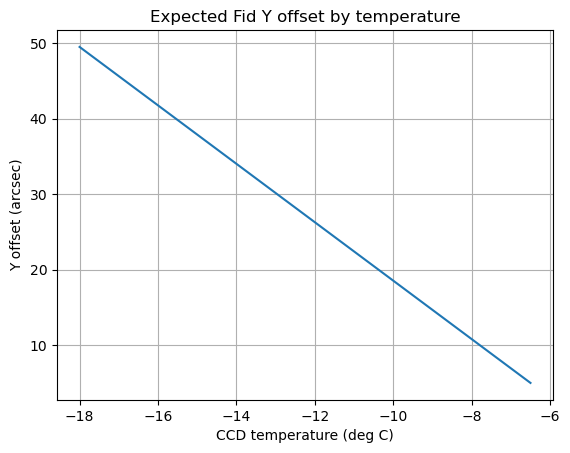

In [28]:
t_ccd = np.arange(-18, -6, .5)
time = CxoTime.now()
drift_y = AcaDriftModel(**DRIFT_PARS['dy']) 
dy = drift_y.calc(time, t_ccd)
plt.plot(t_ccd, -1 * dy + 19.6, label='expected y offset')
plt.title('Expected Fid Y offset by temperature')
plt.ylabel('Y offset (arcsec)')
plt.xlabel('CCD temperature (deg C)')
plt.grid()

In [24]:
t_ccd[-1 * dy + 19.6 < 45][0]

-16.5

Given our fid acquisition performance in the 2022:294 to 2023:047 epoch, where we did not fail to acquire despite fid offsets of up to 25 arcsecs (and search box hw 20), we anticipate that up to 45 arcsec offsets are acceptable (currect search box 40 arcsecs hw).  Based on the current data, this corresponds to a CCD temperature of ~-16.5.  As such our -14C limit is *reasonable* and allows for ACA CCD model error.